## <strong>Psych 4631 Final Project: A model for homonym semantic categorization</strong>
#### 04 / 28 / 2024
#### Rose Liu, Chris Gu
#### <strong>Description</strong>: 

The project aims to build a model to categorize semantics of homonyms(i.e. words that have a single spoken and written form that refers to multiple unrelated concepts(Rodd et al.,2004)) based on the contexts they appear within. Specifically, to start small, the model is built to <strong>categorize two meanings of the word "bank": 1. bank as in "river bank" and 2. bank as a financial institution.</strong> The whole pipeline includes input processing, model construction, training, and testing.

* We take this project as a precious chance to deepen our understanding of neural network, as well as to learn, try, and apply new, more complex model to realize our conceptual ideas on semantic processing. This project may not be exactly reflecting a complete cognitive process and/or building a model from scratch, but we hope that by doing this, we would be able to obtain more insights into how semantic processing can be possibly modeled. We really appreciate the thought process of putting our abstract ideas into tangible work step by step, and we hope we could extend this project further and deeper later on!

In [1]:
# Import useful packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### <strong>1. Input processing</strong>

In [2]:
# Import packages for input processing: nltk for text conversion, filtering, etc, regex for finding matching patterns
import nltk
from nltk.corpus import stopwords
import string
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/guyueping/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guyueping/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### <strong>1.1 Dataset Preparation</strong>
* In the first stage, our dataset contains 600 sentences in total, 300 sentences for each of the two meanings of "bank". 


In [3]:
#Loading Dataset (sentences generated with Chatgpt)
river_path = '/Users/guyueping/Documents/Spring2024/Psych4631/project/river_bank_inputs.txt' #need to change path
financial_path = '/Users/guyueping/Documents/Spring2024/Psych4631/project/financial_bank_inputs.txt' #need to change path

with open(river_path, 'r', encoding='utf-8') as file:
    river_sentences = [line.strip() for line in file]
with open(financial_path, 'r', encoding='utf-8') as file:
    financial_sentences = [line.strip() for line in file]

#### <strong>1.2 Data Pre-processing </strong>
* Convert and filter the sentences to make them cleaner, and ensure consistent formatting for the target word 'bank'.

In [4]:
# Get lists of stopwords and punctuations
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [5]:
def filter_sentence(sentence):

    # Tokenize each sentence into a collection of words in a list form
    words = nltk.word_tokenize(sentence)
    filtered_words = []
    prev_word = None

    for word in words:
        
        # Get rid of possessive case if it immediately follows the target word
        if word.lower() == "banks":
            word = "bank"
            
        # For the target word, replace the plural form with sigular form 
        if word.lower() == "'s" and prev_word == "bank":
            continue
            
        # Remove stopwords and punctuations
        if word.lower() not in stop_words and word not in punctuation:
            filtered_words.append(word)
        prev_word = word

    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

In [6]:
filtered_financial_sentences = [filter_sentence(sentence) for sentence in financial_sentences]

print(len(filtered_financial_sentences))
print (filtered_financial_sentences)

300
['deposit check withdraw cash need visit bank', "loan application new house approved bank 'm excited move soon", 'local bank John works teller helping customers transactions inquiries', 'Various financial services including savings accounts loans investment options offered bank customers', 'Recently bank interest rates increased affecting mortgage rates loan repayments', 'Managing bank wealth management division Sarah advises clients investment strategies financial planning', 'New security measures implemented bank protect customers accounts fraud identity theft', 'Plans expand operations new markets introduce innovative banking products announced bank CEO', 'financial literacy workshop educate customers budgeting saving investing hosted bank', 'anywhere customers access accounts conduct transactions using bank online banking platform', 'Providing convenient access banking services customers bank branch network spans across country', 'Exceeding analysts expectations bank quarterly 

In [7]:
filtered_river_sentences = [filter_sentence(sentence) for sentence in river_sentences]
print(len(filtered_river_sentences))
print (filtered_river_sentences)

300
['children played bank river skipping stones watching fish swim', 'picnic grassy bank river enjoying cool breeze serene atmosphere', 'Ducks swimming near muddy bank river searching food', 'fishing boat docked edge river bank unloading catch day', 'Trees provided shade along steep bank river offering peaceful retreat summer heat', 'heron stood motionless river bank waiting patiently next meal', 'river bank teeming life frogs croaking birds chirping nearby trees', 'campers set tents sandy bank river enjoying sounds nature', 'jogger followed trail along river bank breathing fresh air admiring scenery', 'river bank eroding due heavy rainfall increased water flow', 'Wildflowers bloomed along river bank adding vibrant colors landscape', 'kayakers paddled along winding river passing lush greenery river bank', 'Fishermen cast lines rocky bank river hoping big catch', "deer emerged dense foliage river bank cautiously approaching water 's edge", 'sunset cast golden glow calm waters river ill

In [8]:
# Create a large list containing all sentences -- this is going to be fed into the model
all_sentences = filtered_river_sentences + filtered_financial_sentences

# Create binary labels: 0 for river, and 1 for financial -- for prediction
river_labels = [0] * len(river_sentences)
financial_labels = [1] * len(financial_sentences)
all_labels = river_labels + financial_labels

#### <strong>1.3. Input Tokenization and Embedding</strong>

In [9]:
# Import useful packages: tensorflow, keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

##### <strong>Tokenization
* Convert sentences into collections of individual words for further vectorization</strong>
* Apply keras in tensorflow to tokenize every sentence in the dataset

In [10]:
tokenizer = Tokenizer()

# This code gives each unique word a unique integer mark
tokenizer.fit_on_texts(all_sentences)

# Tokenize each sentences in the form of word collections
tokenized_in_int_sentences = tokenizer.texts_to_sequences(all_sentences)

# Make sure that the inputs are of equal lengths: attaching 0 to the end of each tokenized sentence that is shorter than the longest sentence
padded_sequences = pad_sequences(tokenized_in_int_sentences, padding='post')
padded_sequences.shape

(600, 17)

##### <strong>Embedding</strong>

* In order to feed the input into a neural network, we need to convert each tokenized word (already represented by integers) into the form of a numerical vector. The entries of the vector are generated by capturing the word's contextual and semantic relations with other words. Since each word will be converted into such a vector, we will end up getting an <strong>embedding matrix</strong> with rows being the different words we have in our input dataset, and columns being the vector for each unique word.
* Since our dataset starts fairly small, rather than creating our own embedding layer from scratch(which may increase the risk of not being able to grab and incoporate exhausitve contextual variances or overfitting), we will apply the pre-existing <strong>GoogleNews-vectors-negative300 Word2Vec embeddings</strong>, which is trained on a large corpus(Google News) to get the embeddings for words, and at the same time enable <strong>fine-tuning to our dataset</strong>. This can be conceptualized as a 'base' of our data.

In [11]:
# Import useful packages: KeyedVectors -- text-form words into numerical vectors
from gensim.models import KeyedVectors

In [12]:
# Load pretrained Word2Vec embeddings
words_vec = KeyedVectors.load_word2vec_format('/Users/guyueping/Documents/Spring2024/Psych4631/project/GoogleNews-vectors-negative300.bin', binary=True) #need to change path

# Prepare the embedding matrix
# Initialize the matrix with one additional row(to 1. deal with sentence padding; 2. resolve indexing issue, as word_index's index starts from 1 instead of 0)
# Column: the dimension needed to represent one word
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, words_vec.vector_size))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = words_vec[word]
        embedding_matrix[i] = embedding_vector
        
    # If the word is not found in the pretrained dataset, put a zero vector instead
    except KeyError:
        embedding_matrix[i] = np.zeros(words_vec.vector_size)

In [13]:
print(embedding_matrix.shape)

(2041, 300)


### <strong>2. Network Building</strong>
* We built a 3-layer model: an embedding layer, a LSTM layer, and a dense(fully connected) layer. We utilized TensorFlow, particularly its high-level Keras API. 

In [14]:
# Import tensorflow packages to actually build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

##### <strong>2.1: Embedding Layer (1st layer)</strong>
This layer takes indexed words as input and transforms them into dense vectors 

In [15]:
from tensorflow.keras.initializers import Constant

In [16]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = words_vec.vector_size

# Create the embedding layer with trainable set to "True", which means the matrix can be fine-tuned to our input dataset
embedding_layer = Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=True)

##### <strong>2.2: Bidirectional LSTM Layer (2nd layer)</strong>
* We chose to construct a <strong>Long Short-Term Memory(LSTM)</strong> layer, which is a specific type of recurrent neural network(RNN) that is able to take context into account. Our inspiration is built upon Lab 3.3, which provided us with basic understanding of the bottom frame/groundword of RNN. In our project, rather than learning RNN on a restricted, simple pattern like Reber grammar, we expand this to a much larger scale on a wider range of linguistic inputs.
* We chose to do make the LSTM bidirectional, which enables sequential processing of words both
* 1.from beginning to the end of the sentence; 
* 2.from the end going backwards to the beginning of the sentence.

In [17]:
# Set 128 LSTM units in the LSTM layer
hidden_dim = 128
biLSTM_layer = Bidirectional(LSTM(hidden_dim))

##### <strong>2.3: Fully Connected(FC) Layer (3rd layer)</strong>

Here we have a fully connected neural network layer where every input is connected to every output by a learned weight. This layer combine features learned by the network into predictions for the task

In [18]:
# Set one output: binary, inicating the meaning of "bank" in the sentence
output_dim = 1
dense_layer = Dense(output_dim, activation='sigmoid')

##### <strong>2.4: Construct and Compile the Model

In [19]:
# Compile the model using Adaptive Moment Estimation(Adam) optimization function
from tensorflow.keras.optimizers import Adam

In [20]:
# Construct the model structure and add all layers
model = Sequential()
model.add(embedding_layer)
model.add(biLSTM_layer)
model.add(dense_layer)

# Minimize cross entropy and get the optimized parameters
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

### <strong>3. Training and Testing</strong>

In [21]:
# Import useful packages
from sklearn.model_selection import train_test_split

In [22]:
# Split data into training, validation, and testing sets, ratio 7:2:1
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, all_labels, test_size=0.1, random_state=42, stratify=all_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42, stratify=y_train_val)

# Convert data types
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_val = np.array(X_val).astype('float32')
y_val = np.array(y_val).astype('float32')
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

##### <strong>3.1: Train the model</strong>

In [23]:
# Train the model
training_history = model.fit(X_train, y_train, batch_size=32, shuffle = True, epochs=10, validation_data=(X_val,y_val))

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8414 - loss: 0.5414 - val_accuracy: 1.0000 - val_loss: 0.0203
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9940 - loss: 0.0206 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9917 - val_loss: 0.0262
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3389e-04 - val_accuracy: 0.9917 - val_loss: 0.0227
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4929e-04 - val_accuracy: 0.9917 - val_loss: 0.0153
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.1988e-04 - val_accuracy: 0.9917 - val_loss: 0.0167
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 1.9466e-04 - val_accuracy: 0.9917 - val_loss: 0.0181
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 1.7187e-04 - val_

##### <strong> Plot training history </strong>

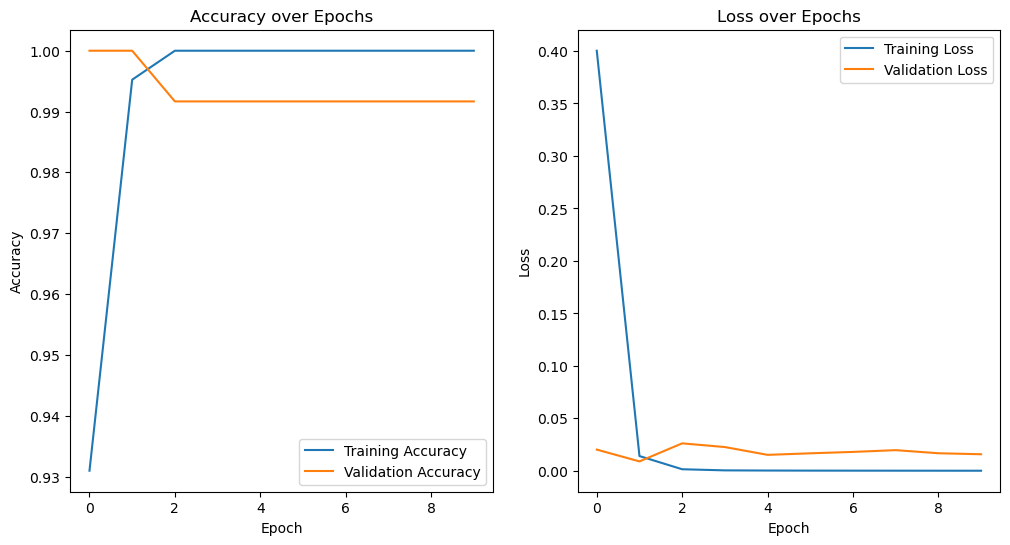

[1.0, 1.0, 0.9916666746139526, 0.9916666746139526, 0.9916666746139526, 0.9916666746139526, 0.9916666746139526, 0.9916666746139526, 0.9916666746139526, 0.9916666746139526]


In [24]:
# Plot the training history for accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(training_history.history['val_accuracy'])

Accuracy over Epochs: 
* Training Accuracy: Starts at approximately 0.8 and sharply increases to near 1.000 (perfect accuracy) by the third epoch. This suggests that the model rapidly learns to classify the training data accurately. The initial high accuracy might be due to pre-trained word embeddings. 
* Validation Accuracy: Begins similarly high and makes a significant jump between the second and third epochs. There's a slight decline around the fourth epoch before it stabilizes close to 1.000. The high validation accuracy indicates that the model generalizes well to new data not seen during training.

Loss over Epochs
* Training Loss: Shows a steep decrease from the initial epoch, dropping close to zero by the third epoch. This demonstrates that the model quickly minimizes the error in predictions for the training data.
* Validation Loss: Mirrors the sharp decline seen in the training loss and levels off to a low value, with a small peak at the third epoch. The overall low validation loss corroborates the model's effectiveness on the validation set. 

Note: Given that we have a small dataset and a simple task, it is reasonable to see the rapid improvement in both accuracy and loss during the first few epochs. 

##### <strong>3.2: Test the model</strong>
* Test the model on pre-splitted testing set, check for accuracy

In [25]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

2/2 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0022
Test Accuracy: 100.00%
Test Loss: 0.0022


In [26]:
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Print first 10 predictions
for i in range(10):
    print(f"Sentence: {tokenizer.sequences_to_texts([X_test[i]])}")
    print(f"Predicted: {'Financial Bank' if predicted_classes[i][0] == 1 else 'River Bank'}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Sentence: ['bank part larger effort create green spaces along river']
Predicted: River Bank
Sentence: ['photographers captured sunrise bank early light turning river molten gold']
Predicted: River Bank
Sentence: ['contributed articles bank ’ financial education blog sharing insights market dynamics']
Predicted: Financial Bank
Sentence: ['bank ’ fraud alert system notified suspicious activity account']
Predicted: Financial Bank
Sentence: ['lone fisherman stood river bank dawn line cast quiet waters']
Predicted: River Bank
Sentence: ['small jetty jutted river bank launching point small rowboats canoes']
Predicted: River Bank
Sentence: ['bank organized financial boot camp young entrepreneurs']
Predicted: Financial Bank
Sentence: ['bank ’ local art sponsorship program helped foster community relations']
Predicted: Financial Bank
Sentence: ["birdwatchers set tripods capturing shots migrating birds along river 's bank"]
Predicted: River Bank
Sentence: ['

##### <strong>3.2.1: Further testing(1): check model performance on new sentences that are not included in the dataset.</strong>
* We generated 50 new sentences each for financial bank and river bank sentences, and tested the prediction accuracy.

In [27]:
Test_New_Input = [
    "The bank manager agreed to extend the loan term.",
    "We met with our financial advisor at the bank to discuss investment options.", 
    "The bank's new policy on overdraft fees took effect last week.", 
    "I deposited my paycheck at the bank yesterday.",
    "After moving to the city, I opened an account at a local bank.", 
    "The bank is offering a higher interest rate on savings accounts this month.", 
    "She applied for a mortgage through her bank.", 
    "The bank's hours are convenient for people who work late.", 
    "He secured a small business loan from the bank.", 
    "The bank installed new ATMs that are easier to use.", 
    "Her bank statement shows several transactions she doesn't recognize.",     
    "The bank approved their loan application after a lengthy review.", 
    "They are considering switching banks due to better customer service elsewhere.", 
    "The bank sent an alert about possible fraudulent activity on my account.", 
    "I need to stop by the bank to get some cash.", 
    "The bank's mobile app makes managing finances very convenient.", 
    "She recommended her bank because of their excellent customer support.", 
    "The bank is sponsoring a community event next weekend.", 
    "He worked at the bank for over 15 years before retiring.", 
    "The bank's new branch downtown features modern technology and design.", 
    "Their bank offers a range of credit cards with various rewards programs.", 
    "I have an appointment at the bank to discuss refinancing my home.", 
    "The bank closed several branches to cut costs.", 
    "She uses her bank’s online platform to pay bills and transfer money.", 
    "The bank has a special program for first-time homebuyers.", 
    "He complained about the bank's high fees for wire transfers.", 
    "The bank announced a merger with another financial institution.", 
    "She was recognized as the bank’s employee of the month.", 
    "AdamThe bank requires two forms of ID to open a new account.", 
    "The bank's credit analyst reviewed the loan file thoroughly.", 
    "He is unhappy with the interest rates his bank offers.", 
    "The bank’s foreign exchange service is very useful for travelers.", 
    "They chose a bank that offers both personal and business banking services.", 
    "The bank's annual report shows a significant profit.", 
    "She’s thinking about switching to a bank with no monthly fees.", 
    "The bank offers financial literacy workshops for teenagers.", 
    "He set up a recurring payment through his bank’s bill pay service.", 
    "The bank provides a notary service free of charge for account holders.", 
    "Their bank was robbed yesterday, but no one was injured.", 
    "The bank’s mortgage rates are competitive with other local institutions.", 
    "She lost her bank card and had to request a new one.", 
    "The bank’s customer satisfaction ratings have improved this year.", 
    "He uses the bank’s chat service for quick questions about his account.",
    "The bank offers a high-yield account for larger deposits.", 
    "She was cautious about giving out her bank details online.", 
    "The bank's loan officer provided several options to consider.", 
    "He appreciated the bank’s efforts to secure his financial information.", 
    "The bank is recognized for its commitment to environmental sustainability.", 
    "They received a bank statement that detailed all last month’s transactions.",
    "She negotiated a better interest rate with her bank.",
    "We set up our picnic on the grassy river bank.",
    "The river bank was crowded with fishermen early in the morning.", 
    "They walked along the bank, looking for a good spot to swim.", 
    "The river's bank was steep and slippery after the rain.", 
    "Wildflowers grew abundantly along the sunlit bank.", 
    "Kids were playing and splashing near the river bank.", 
    "The bank of the river was a popular spot for bird watching.", 
    "We found a quiet place on the bank to sit and talk.", 
    "The floodwaters rose, threatening to breach the river bank.", 
    "They built a small fire on the bank as the sun set.", 
    "The hiking trail followed the river bank for several miles.", 
    "The bank was eroding, and the trees were at risk of falling into the river.", 
    "Animals frequently visited the river bank to drink in the cool of the evening.", 
    "She sketched the peaceful scene from the bank.", 
    "The bank was dotted with footprints from various wildlife.", 
    "Every summer, they camped on the same river bank.", 
    "The bank was a mix of sand and rocks, ideal for skipping stones.", 
    "She collected shells along the wet bank of the river.", 
    "The river bank offered a perfect view of the sunrise.", 
    "They noticed tracks along the bank leading to the water’s edge.", 
    "The bank had been reinforced with boulders to prevent erosion.", 
    "Wild horses were seen grazing near the river bank.", 
    "He taught his son to fish from the bank.", 
    "The festival was held on the wide bank of the river.", 
    "A wooden bench was installed on the bank for visitors to enjoy the view.", 
    "The river bank was lined with willow trees, their branches touching the water.",
    "Local artists painted the serene bank at dusk.", 
    "They explored the river bank, looking for interesting rocks.", 
    "The river bank was a vital habitat for local wildlife.", 
    "Flood markers showed how high the water had reached on the bank.", 
    "The children built a sandcastle on the muddy bank.", 
    "Birdwatchers gathered at the river bank to observe migrating ducks.", 
    "The bank was the perfect spot for their annual family photo.", 
    "A beaver dam was visible from the opposite bank.", 
    "The river bank was quieter in the fall, as tourists left for the season." ,
    "Kayakers pulled up onto the bank to rest and eat lunch.", 
    "They found an old canoe half-buried in the bank.", 
    "The bank was a riot of color in spring with all the wildflowers blooming.", 
    "The river bank was a popular jogging path for locals.", 
    "He proposed to her on the bank under the stars.", 
    "A gentle slope led down to the river bank, making access easy.", 
    "The bank was covered in a blanket of snow in the winter.", 
    "They planted trees along the bank to help stabilize the soil.", 
    "The bank was a perfect natural amphitheater for the concert.", 
    "She left small pebbles on the bank as markers for her return journey.", 
    "The campers were advised to keep their site clean on the river bank.", 
    "Footbridges spanned the narrowest parts of the bank.", 
    "He found an old fishing lure tangled in the bushes on the bank.", 
    "The river bank echoed with the sounds of frogs at night.", 
    "They had a tradition of watching the fireworks show from the river bank."    
]

In [28]:
test_new_sequences = tokenizer.texts_to_sequences(Test_New_Input)
test_new_padded = pad_sequences(test_new_sequences, padding='post')
X_new_test = np.array(test_new_padded).astype('float32')

new_predictions = model.predict(X_new_test)
new_predicted_classes = (new_predictions > 0.5).astype(int)
for i in range(len(X_new_test)):
    print(f"Sentence: {Test_New_Input[i]}")
    print(f"Predicted: {'Financial Bank' if new_predicted_classes[i][0] == 1 else 'River Bank'}")

new_predicted_classes_fsentences = new_predicted_classes[0:50]
new_predicted_classes_rsentences = new_predicted_classes[51:100]
print("Prediction accuracy for bank-financial:")
print(len(new_predicted_classes_fsentences[new_predicted_classes_fsentences == 1])/50)
print("Prediction accuracy for bank-river:")
print(len(new_predicted_classes_rsentences[new_predicted_classes_rsentences == 0])/50)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sentence: The bank manager agreed to extend the loan term.
Predicted: Financial Bank
Sentence: We met with our financial advisor at the bank to discuss investment options.
Predicted: Financial Bank
Sentence: The bank's new policy on overdraft fees took effect last week.
Predicted: Financial Bank
Sentence: I deposited my paycheck at the bank yesterday.
Predicted: Financial Bank
Sentence: After moving to the city, I opened an account at a local bank.
Predicted: Financial Bank
Sentence: The bank is offering a higher interest rate on savings accounts this month.
Predicted: Financial Bank
Sentence: She applied for a mortgage through her bank.
Predicted: Financial Bank
Sentence: The bank's hours are convenient for people who work late.
Predicted: Financial Bank
Sentence: He secured a small business loan from the bank.
Predicted: Financial Bank
Sentence: The bank installed new ATMs that are easier to use.
Predicted: Financial Bank
Sentence: Her bank state

We can see that prediction of bank-financial sentences achieved an accuracy of 1.0, and prediction of bank-river sentences achieved an accuracy of 0.96. This suggests that our model has good ability to be generalized to new inputs.

##### <strong>3.2.2: Further testing(2): check and compare model performance on rich-context sentences and poor-context sentences.</strong>
* In this part of further testing, we want to validate again that the sentence context influences/decides the model's prediction. Therefore, we generated 100 high-context "financial bank" sentences and 100 "low-context" sentences where the meaning of "bank" is hard to tell(i.e context is insufficient/unclear). We expect that the percentage of predicting "bank" as "financial bank" would be much higher for the high-context sentences, and the low-context sentences may get random predictions yielding this percentage to be around 0.5.

In [29]:
# 100 high-context sentences that clearly indicate "bank-financial"
new_input_highContext = [
    "She deposited her paycheck at the bank yesterday.",
    "The bank approved my loan application this morning.",
    "I need to stop by the bank to get some cash.",
    "He works as a manager at the local bank.",
    "The bank's interest rates have gone up again.",
    "She discussed her mortgage options with the bank officer.",
    "The bank is closed on weekends and public holidays.",
    "I received a fraud alert from my bank this afternoon.",
    "The bank has several branches throughout the city.",
    "He needs to transfer money from his bank account.",
    "She regularly checks her bank statements for any discrepancies.",
    "The bank's ATM was out of service.",
    "He got a better credit card offer from another bank.",
    "She set up a savings account at the bank for her son.",
    "The bank's customer service has really improved.",
    "I have to go to the bank to close my account.",
    "The bank granted them a home improvement loan.",
    "He complained about the hidden fees his bank charged him.",
    "She works in the bank's corporate headquarters downtown.",
    "The bank's new policy will affect many customers.",
    "He was waiting in line at the bank for half an hour.",
    "The bank's new app lets you manage your finances more easily.",
    "She forgot her PIN at the bank machine.",
    "The bank issued a recall of defective credit cards.",
    "He is consulting with his bank about investing in stocks.",
    "The bank offers a good interest rate for time deposits.",
    "She was impressed by the bank's quick response to her query.",
    "The bank is offering a seminar on personal finance management.",
    "He chose that bank because it has no annual fees.",
    "The bank's fraud prevention system is very sophisticated.",
    "She was awarded employee of the month by her bank.",
    "The bank's branch near my house is very convenient.",
    "He reviews his bank transactions every week.",
    "The bank is renovating its main lobby.",
    "She needed a bank statement to apply for a visa.",
    "The bank has a special offer for new clients.",
    "He disputed a charge on his bank account.",
    "The bank provides excellent financial advisory services.",
    "She uses her bank's mobile app to pay bills.",
    "The bank's website was down for maintenance yesterday.",
    "He received a promotional email from his bank.",
    "The bank's loan officer explained the terms clearly.",
    "She appreciates the bank's effort to go green.",
    "The bank's annual report showed significant profit.",
    "He got a secure job at a bank.",
    "The bank's wire transfer fees are quite high.",
    "She negotiated a lower interest rate with the bank.",
    "The bank has a strict policy on loan repayments.",
    "He used the bank's night deposit service.",
    "The bank will charge a penalty for early withdrawal of the fixed deposit.",
    "She was directed to the bank's helpdesk for assistance.",
    "The bank offers free financial planning consultations.",
    "He was worried about the bank's solvency during the crisis.",
    "The bank's quarterly earnings exceeded expectations.",
    "She recommended her bank to her friends.",
    "The bank requires two forms of ID to open an account.",
    "He read a review about the bank online.",
    "The bank's parking lot is always full.",
    "She was greeted warmly at the bank.",
    "The bank's credit card has the best rewards program.",
    "He checked the bank's stock price online.",
    "The bank's teller was very helpful.",
    "She attended a mortgage workshop hosted by the bank.",
    "The bank is known for its charitable donations.",
    "He updated his contact information at the bank.",
    "The bank has installed new security cameras.",
    "She got a job offer from a top bank.",
    "The bank will hold her check for three days before it clears.",
    "He is responsible for auditing the bank's accounts.",
    "The bank's branch manager was promoted.",
    "She was confused by the bank's new regulations.",
    "The bank's annual picnic is next weekend.",
    "He used the bank's calculator to estimate his loan.",
    "The bank sent him a new debit card.",
    "She closed her higher-interest bank account.",
    "The bank is very strict about its dress code.",
    "He chose the bank based on its ethical investment policies.",
    "The bank has several automated teller machines in the area.",
    "She was contacted by the bank regarding her account security.",
    "The bank's financial analysts are forecasting growth.",
    "He was annoyed by the bank's slow loan processing.",
    "The bank has a branch at the airport.",
    "She had to provide her social security number to the bank.",
    "The bank reimbursed him for the ATM fee.",
    "He's reading a history of the oldest banks in the country.",
    "The bank's marketing campaign is targeting young adults.",
    "She received a letter from the bank confirming her address change.",
    "The bank's board of directors met yesterday.",
    "He was impressed by the bank's community involvement.",
    "The bank is participating in a federal loan program.",
    "She set a password for her bank account online.",
    "The bank's lobby features art from local artists.",
    "He reviewed the bank's policies before opening an account.",
    "The bank's safety deposit boxes are almost fully booked.",
    "She uses only her bank's ATMs to avoid fees.",
    "The bank's building is a city landmark.",
    "He learned about the bank's student loan options.",
    "The bank's investment in technology has paid off.",
    "She has to update her beneficiary information at the bank.",
    "The bank plans to expand its operations next year.",
]

# 100 low-context sentences where "bank"'s meaning is ambiguous/hard to be determined
new_input_lowContext = [
    "She mentioned going to the bank before it closed.",
    "They found the bank quiet that afternoon.",
    "We'll meet at the bank after lunch.",
    "He left his notebook on the bank.",
    "There are plans to renovate the old bank.",
    "She took a job at the bank downtown.",
    "The bank was unusually busy today.",
    "After discussing their plans at the bank, they decided to have lunch by the water.",
    "She found the bank quite relaxing and spent the afternoon there contemplating her next steps.",
    "He walked past the bank on his way to the park.",
    "They decided to paint the bank over the weekend.",
    "I'll see you at the bank tomorrow morning.",
    "The bank is closed on Sundays.",
    "She often spent time sitting by the bank.",
    "They discussed the situation on their way to the bank.",
    "He noticed something unusual at the bank.",
    "She stopped by the bank during her run.",
    "They had their picnic near the bank.",
    "He dropped his keys near the bank.",
    "The bank seemed deserted that evening.",
    "She worked late at the bank again.",
    "They held a meeting at the bank to discuss the project.",
    "He waited outside the bank for her.",
    "The children played near the bank while waiting.",
    "She left her bag at the bank.",
    "He couldn't find the bank at first.",
    "They had an argument near the bank.",
    "She usually takes a break at the bank.",
    "The bank was a popular spot for lunch.",
    "He made a quick stop at the bank.",
    "She jogged past the bank every morning.",
    "The bank was a central point in their neighborhood.",
    "They planned to meet by the bank.",
    "He often thought about the old stories of the bank.",
    "The bank had a small garden beside it.",
    "She was surprised to see him at the bank.",
    "The bank was mentioned briefly in her book.",
    "He couldn't remember the way to the bank.",
    "She recommended a visit to the bank.",
    "The bank had been there for over a century.",
    "They took a walk past the bank.",
    "He talked about the bank with nostalgia.",
    "She left a note at the bank.",
    "The bank was visible from their house.",
    "He found an old photo of the bank.",
    "She mentioned the bank in her story.",
    "The bank was closed when they arrived.",
    "He felt uneasy near the bank.",
    "She wrote about the bank in her diary.",
    "The bank was a fixture in their childhood stories.",
    "They played games near the bank.",
    "He thought he saw her near the bank.",
    "The bank had an unusual shape.",
    "She missed the turn to the bank.",
    "The bank was part of their routine.",
    "He found a wallet near the bank.",
    "She took pictures of the bank.",
    "The bank was mentioned in the local news.",
    "He fixed the sign at the bank.",
    "She often passed the bank on her walks.",
    "The bank had a new owner.",
    "He saved a kitten near the bank.",
    "She learned to drive around the bank area.",
    "The bank was a quiet place during the week.",
    "He read a book about the history of the bank.",
    "She felt nostalgic about the bank.",
    "The bank had a quaint appearance.",
    "He often sat near the bank to think.",
    "She set up her easel near the bank.",
    "The bank was part of the town's heritage.",
    "He lost his watch near the bank.",
    "She found her old friend at the bank.",
    "The bank was under new management.",
    "He had memories of playing at the bank.",
    "She found an interesting plant near the bank.",
    "The bank was often overlooked by tourists.",
    "He talked about his experiences at the bank.",
    "She felt a connection to the bank.",
    "The bank was part of their daily view.",
    "He helped clean up the area around the bank.",
    "She had her first job at the bank.",
    "The bank was a landmark in their community.",
    "He remembered the old tree by the bank.",
    "She always remembered the view from the bank.",
    "The bank was a meeting point for many.",
    "He found solace at the bank.",
    "She often brought visitors to see the bank.",
    "The bank was a topic of many local stories.",
    "He was drawn to the solitude of the bank.",
    "She thought of the bank as a peaceful place.",
    "The bank had changed little over the years.",
    "He always included the bank in his tours.",
    "She considered the bank a part of her life.",
    "The bank was well-known for its quiet.",
    "He felt peace near the bank.",
    "She used to think about the future at the bank.",
    "The bank was a place of reflection.",
    "He was surprised by the calmness of the bank.",
    "She liked the atmosphere around the bank.",
    "The bank was a scene of many early mornings."
]

In [30]:
new_input_highContext = [sentence.lower() for sentence in new_input_highContext]
new_input_lowContext = [sentence.lower() for sentence in new_input_lowContext]

sequences_highContext = tokenizer.texts_to_sequences(new_input_highContext)
sequences_lowContext = tokenizer.texts_to_sequences(new_input_lowContext)

padded_sequences_highContext = pad_sequences(sequences_highContext,padding='post')
padded_sequences_lowContext = pad_sequences(sequences_lowContext,padding='post')

predictions_highContext = model.predict(padded_sequences_highContext)
predicted_classes_highContext = (predictions_highContext > 0.5).astype(int)

predictions_lowContext = model.predict(padded_sequences_lowContext)
predicted_classes_lowContext = (predictions_lowContext > 0.5).astype(int)

# print(predicted_classes_highContext)
print("High_context: % of predicting 'bank' as financial institution:")
print(len(predicted_classes_highContext[predicted_classes_highContext == 1])/len(predicted_classes_highContext))
# print(predicted_classes_lowContext)
print("Low-context: % of predicting 'bank' as financial institution:")
print(len(predicted_classes_lowContext[predicted_classes_lowContext == 1])/len(predicted_classes_lowContext))

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/stepWARNING:tensorflow:5 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x28e8b3ce0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
High_context: % of predicting 'bank' as financial institution:
0.91
Low-context: % of predicting 'bank' as financial institution:
0.46


The results show a significant influence of sentence context on the model's predictive accuracy. When presented with 100 high-context sentences where the word "bank" clearly referred to a financial institution, the model achieved a high accuracy of 91%. However, in 100 low-context sentences, where the meaning of "bank" was ambiguous, the model's accuracy dropped to 46%, which is not better than a random guess. This indicates the model's reliance on strong contextual cues and difficulty with ambiguity. This highlights the model's strength in clear contexts and suggests areas for improvement in handling ambiguous scenarios. 